# Q1
#Start the hadoop <br>
$./startHadoop.sh <br>

#Start hive <br>
$hive<br>

#create external table to read the data <br>
hive> create external table boston_ext (CRIM float,ZN<br>float,INDUS float,CHAS int,NOX float,RM float,AGE float,DIS float,<br>
    > RAD int,TAX int,PT float, B float,LSTAT float, MV float)<br>
     > comment "House price distribution"<br>      
     > row format delimited<br>
     > fields terminated by ','<br>
     > lines terminated by '\n'<br>
     > stored as textfile<br>
     > location '/input'<br>
     > tblproperties("skip.header.line.count"="1");



In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import HiveContext
from pyspark.ml.regression import LinearRegression

# Q2

In [3]:
#Create spark session with enabled hive
spark = SparkSession.builder\
.appName("ReadingBostonDataFromHive")\
.master("local")\
.enableHiveSupport()\
.getOrCreate()

In [6]:
#Read the file using pyspark
df = spark.sql("Select * from boston_ext where crim is not null")

In [7]:
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|  pt|     b|lstat|  mv|
+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
only showing top 5 rows



In [14]:
df.printSchema()

root
 |-- crim: float (nullable = true)
 |-- zn: float (nullable = true)
 |-- indus: float (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: float (nullable = true)
 |-- rm: float (nullable = true)
 |-- age: float (nullable = true)
 |-- dis: float (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- pt: float (nullable = true)
 |-- b: float (nullable = true)
 |-- lstat: float (nullable = true)
 |-- mv: float (nullable = true)



In [17]:
#Shape of the data
print(df.count(), len(df.columns))


506 14


In [18]:
#columns in the dataset
df.columns

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'pt',
 'b',
 'lstat',
 'mv']

In [32]:
df.describe().show(2,False)

+-------+------------------+------------------+------------------+------------------+------------------+---------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|crim              |zn                |indus             |chas              |nox               |rm             |age              |dis               |rad              |tax              |pt                |b                |lstat            |mv                |
+-------+------------------+------------------+------------------+------------------+------------------+---------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|count  |506               |506               |506               |506               |506               |506            |506              |506               |506              |506              |506

In [21]:
# Convering dataframe into pandas
df_pd = df.toPandas()

In [23]:
df_pd.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,pt,b,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33,36.200001


In [28]:
#checking for null values
df.na.drop(how='any').show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|  pt|     b|lstat|  mv|
+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+----+------+-----+----+
only showing top 5 rows



There is no missing value in the data

In [29]:
df_pd.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,pt,b,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,50.000000


# Q3

In [25]:
#Correlation 
df_pd.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,pt,b,lstat,mv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355502,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


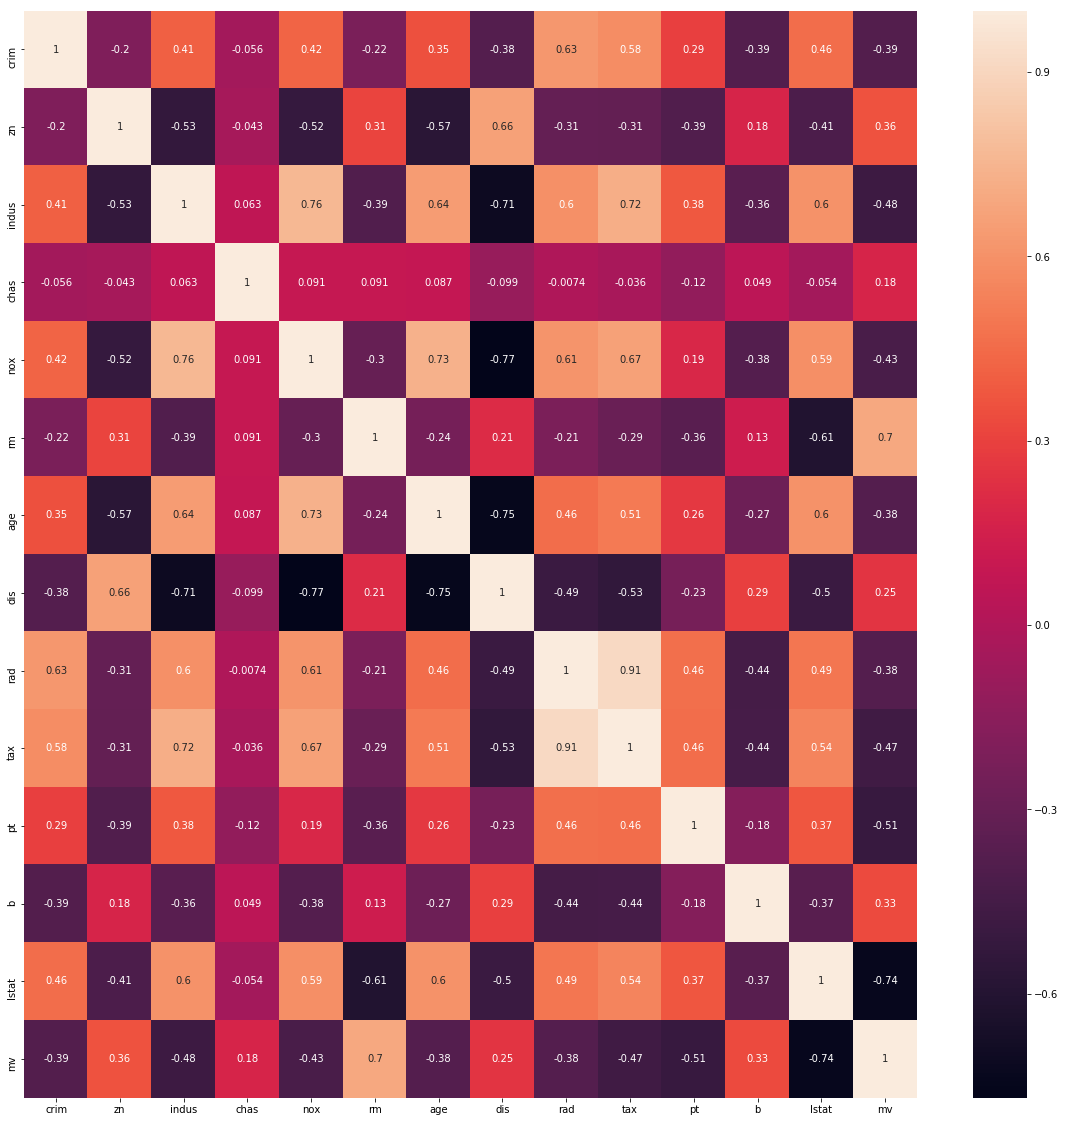

In [35]:
#Heatmap of correation plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(df_pd.corr(),annot=True)

# Q4

In [36]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [37]:
vec_assembler = VectorAssembler(inputCols=['crim','zn','indus',
'chas','nox','rm','age','dis','rad','tax','pt','b','lstat',],
outputCol='features')

In [38]:
feature_df = vec_assembler.transform(df)

In [39]:
#print schema
feature_df.printSchema()

root
 |-- crim: float (nullable = true)
 |-- zn: float (nullable = true)
 |-- indus: float (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: float (nullable = true)
 |-- rm: float (nullable = true)
 |-- age: float (nullable = true)
 |-- dis: float (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- pt: float (nullable = true)
 |-- b: float (nullable = true)
 |-- lstat: float (nullable = true)
 |-- mv: float (nullable = true)
 |-- features: vector (nullable = true)



In [40]:
model_df = feature_df.select('features','mv')
model_df.show()

+--------------------+----+
|            features|  mv|
+--------------------+----+
|[0.00632000016048...|24.0|
|[0.02731000073254...|21.6|
|[0.02728999964892...|34.7|
|[0.03237000107765...|33.4|
|[0.06904999911785...|36.2|
|[0.02985000051558...|28.7|
|[0.08828999847173...|22.9|
|[0.14454999566078...|27.1|
|[0.21123999357223...|16.5|
|[0.17003999650478...|18.9|
|[0.22488999366760...|15.0|
|[0.11747000366449...|18.9|
|[0.09378000348806...|21.7|
|[0.62976002693176...|20.4|
|[0.63796001672744...|18.2|
|[0.62739002704620...|19.9|
|[1.05393004417419...|23.1|
|[0.78420001268386...|17.5|
|[0.80270999670028...|20.2|
|[0.72579997777938...|18.2|
+--------------------+----+
only showing top 20 rows



In [41]:
#Shape of model_df
print((model_df.count()), len(model_df.columns))

506 2


In [42]:
# Splitting the data
train_df,test_df = model_df.randomSplit([0.80,0.20])

In [44]:
#Print the shape of train and test dataset
print("Train:",(train_df.count()), len(train_df.columns))
print("Test:",(test_df.count()), len(test_df.columns))

Train: 396 2
Test: 110 2


In [45]:
#Create the linear regression Object
linear_reg = LinearRegression(labelCol='mv')

In [46]:
#fit the model
lr_model = linear_reg.fit(train_df)

In [51]:
#print the intercept and coeffitient
print("------Intercept-----")
print(lr_model.intercept)
print("------Coeffitient------")
print(lr_model.coefficients)

------Intercept-----
31.990537568834647
------Coeffitient------
[-0.11713513655783052,0.034530609683031614,0.06777919618742867,3.013378966738144,-17.93706885449076,4.282904011316119,-0.001738274250176237,-1.262991831943939,0.28330481239944283,-0.012324256298369545,-0.9614137453332434,0.00990043602651015,-0.4755516410376101]


# Q5

In [56]:
#Prediction on training data
training_predictions = lr_model.evaluate(train_df)

In [57]:
training_predictions.meanSquaredError

20.630034136664023

In [58]:
training_predictions.r2

0.7470754996307993

In [59]:
#Prediction on testing set
test_results = lr_model.evaluate(test_df)

In [53]:
#View the residual error based on prediction
test_results.residuals.show(5)

+------------------+
|         residuals|
+------------------+
|-5.485826441520235|
| 9.611697348163943|
|7.3871340751941545|
|3.8092061676065825|
|0.3008505578085803|
+------------------+
only showing top 5 rows



In [54]:
#R-squared value
test_results.r2

0.7111517314251794

In [55]:
#RMSE
test_results.rootMeanSquaredError

5.22696014517139

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

+--------------------+----+------------------+
|            features|  mv|        prediction|
+--------------------+----+------------------+
|[0.00632000016048...|24.0|29.485826441520235|
|[0.01381000038236...|50.0| 40.38830265183606|
|[0.02009000070393...|50.0|42.612865924805845|
|[0.02728999964892...|34.7| 30.89079459533287|
|[0.02762999944388...|30.8|30.499148679251967|
+--------------------+----+------------------+
only showing top 5 rows



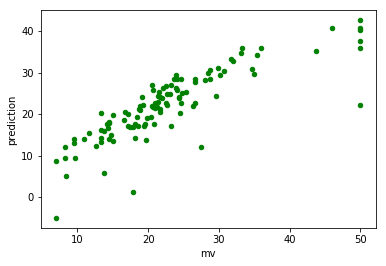

In [64]:
#predict test data
test_results_predict = lr_model.transform(test_df)
test_results_predict_pd = test_results_predict.toPandas()
test_results_predict_pd.plot.scatter(x = 'mv', y='prediction',c='green')
test_results_predict.show(5)